In [1]:
# The code was removed by Watson Studio for sharing.

# Week 4 - Battle of the Neighbourhoods Assignment (Part 1)

## Tasks: 

1. A description of the problem and a discussion of the background. (15 marks)
1. A description of the data and how it will be used to solve the problem. (15 marks)

## 1. Description of the problem, discussion of the background

Problem to solve: When moving a new city, there are numerous neighbourhoods to choose from. One of the considerations to shortlist potential neighbourhoods to live in would be the availability of different services within that neighbourhood. For example, some people might place a high emphasis on the availability and proximity of restaurants and other services, in addition to other common considerations such as proximity to work, ground transport connectivity, demographics, types of accommodation, density, proximity to parks and other public facilities etc. 

In this project, I will specifically be focusing on identifying the different types of amenities (restaurants, cafes, fun, shopping, nightlife - i.e. categories available in Foursquare data) within the various <b>Boston</b> neighbourhoods. I will then analyse which neighbourhoods have the most diverse range of amenities. I will also include population density as well as median home values as parameters to cluster neighbourhoods. Subsequently to analyse the resulting clusters to provide insights into the types of neighbourhood clusters produced by the data.

This project will target people who are moving to Boston for work, and are interested in identifying the best neighbourhoods to live in based on the range and number of different services available, as well as its population density and cost of homes (based on the median home value). This is important to those who value convenience and diversity of options near where they live, as well as have a preference towards how dense the area is, and the relative cost of purchasing a home in those neighbourhoods. 

## 2. Description of the data and how it will be used to solve the problem

### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np

!pip install "uszipcode";# library that provide zipcode related data
from uszipcode import SearchEngine, SimpleZipcode, Zipcode

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes;# uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

    100% |████████████████████████████████| 143kB 5.6MB/s eta 0:00:01
    100% |████████████████████████████████| 204kB 4.5MB/s eta 0:00:01
Requirement not upgraded as not directly required: sqlalchemy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from uszipcode)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from uszipcode)
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pathlib-mate->uszipcode)
    100% |████████████████████████████████| 122kB 7.2MB/s eta 0:00:01
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->uszipcode)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->uszipcode)
Requirement not upgraded as not directly required: urll

###  Obtain Boston's zipcodes from Boston.gov and use `uszipcode` package to populate latitude, longitude, population density and median home value

Extract list of Boston zipcodes from csv file and remove duplicates from the list. Subsequently, to obtain the required data (name, latitutde, longitude, population density and median home value) associated with each zip code using `uszipcode`.

Note that zipcodes in Central Boston do not map to a specific neighbourhood name (limitation of the `uszipcode` package). To bypass this issue, subsequently label each point on map by combination of both its zipcode and name.

### How data will be used:
1. Latitude and Longitude data will be used as inputs to obtain Foursquare data. 
1. Population density and median home value data will be used subsequently to cluster the neighbourhoods. 


In [3]:
# open file with data of Boston neighbourhoods (obtained from Boston's website)
boston_df = pd.read_csv(project.get_file('ZIP_Codes.csv'), dtype={'ZIP5': 'str'})
boston_df = boston_df[['ZIP5']].drop_duplicates()
# create additional columns
boston_df['Name'] = 'Name'
boston_df['Latitude'] = 0.0
boston_df['Longitude'] = 0.0
boston_df['Population_Density'] = 0
boston_df['Median_Home_Value'] = 0
boston_df.head()

,ZIP5,Name,Latitude,Longitude,Population_Density,Median_Home_Value
0,02134,Name,0.0,0.0,0,0
1,02125,Name,0.0,0.0,0,0
2,02110,Name,0.0,0.0,0,0
3,02118,Name,0.0,0.0,0,0
4,02126,Name,0.0,0.0,0,0


In [4]:
# define function to get data for each row in Dataframe using uszipcode
def get_zipcode_data(row): 
    search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database
    zipcode = search.by_zipcode(row['ZIP5'])
    name = zipcode.major_city
    lat = zipcode.lat
    lng = zipcode.lng
    pop_density = zipcode.population_density
    median_value = zipcode.median_home_value
    
    return [zipcode.zipcode, name, lat, lng, pop_density, median_value]

boston_df = boston_df.apply(get_zipcode_data, axis=1).dropna().reset_index(drop=True) # drop rows with NaN

print('Total number of zipcodes in Boston = ', boston_df.shape[0])

boston_df.head()

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!
Total number of zipcodes in Boston =  35


,ZIP5,Name,Latitude,Longitude,Population_Density,Median_Home_Value
0,02134,Allston,42.360,-71.130,16212.0,361900.0
1,02125,Dorchester,42.320,-71.000,15611.0,301200.0
2,02110,Boston,42.359,-71.054,9355.0,724000.0
3,02118,Boston,42.340,-71.070,24075.0,561100.0
4,02126,Mattapan,42.280,-71.090,12277.0,282700.0
5,02109,Boston,42.363,-71.054,21721.0,676700.0
6,02021,Canton,42.180,-71.120,1147.0,425800.0
7,02113,Boston,42.365,-71.055,68665.0,449100.0
8,02130,Jamaica Plain,42.310,-71.120,10618.0,392800.0
9,02121,Dorchester,42.310,-71.080,14884.0,311700.0


### Visualise the distribution of population density and median home values

From the histograms, we can see that median home values and population density are distributed on the lower range across quite a number of zipcodes. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48fbe348d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f48fbbc5048>]], dtype=object)

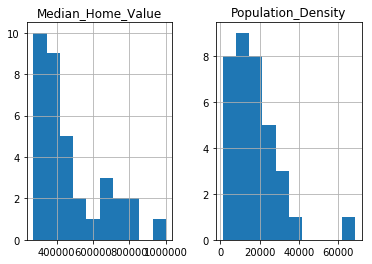

In [25]:
boston_df.hist(column=['Population_Density', 'Median_Home_Value'])

### Visualise Boston and its neighbourhoods

In [5]:
address = 'Boston'

geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [6]:
# create map of Boston using latitude and longitude values
map_boston = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, zipcode in zip(boston_df['Latitude'], boston_df['Longitude'], boston_df['Name'], boston_df['ZIP5']):
    combined_label = zipcode + " " + label
    label = folium.Popup(combined_label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_boston)  
    
map_boston

### Access Foursquare data to get venue information

### How data will be used:
1. Each zipcode will subsequently be analysed to establish which one has the most diverse range of services.
1. Clustering will also be carried out to identify groups of similar zipcodes

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
# Reuse function from lab to get nearby venues near each Borough
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
boston_venues = getNearbyVenues(names=boston_df['ZIP5'],
                                   latitudes=boston_df['Latitude'],
                                   longitudes=boston_df['Longitude']
                                  )

02134
02125
02110
02118
02126
02109
02021
02113
02130
02121
02119
02115
02135
02199
02459
02124
02132
02114
02108
02136
02111
02210
02116
02131
02127
02120
02215
02129
02128
02122
02151
02186
02026
02152
02467


In [10]:
boston_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,02134,42.36,-71.13,Trader Joe's,42.363344,-71.129944,Grocery Store
1,02134,42.36,-71.13,Boston Liquors,42.358027,-71.126793,Liquor Store
2,02134,42.36,-71.13,swissbäkers,42.363194,-71.128565,Bakery
3,02134,42.36,-71.13,Our Fathers Deli,42.363520,-71.129458,Bar
4,02134,42.36,-71.13,The Breakfast Club,42.363326,-71.133548,Diner


In [14]:
print('Unique venue categories in Boston is {}'.format(len(boston_venues['Venue Category'].unique())))

Unique venue categories in Boston is 210


In [17]:
print('Top 10 venue categories in Boston')
boston_venues['Venue Category'].value_counts()[0:10]

Top 10 venue categories in Boston


Italian Restaurant     108
Coffee Shop             56
American Restaurant     43
Seafood Restaurant      42
Pizza Place             37
Bakery                  34
Donut Shop              29
Park                    29
Café                    26
Sandwich Place          25
Name: Venue Category, dtype: int64